# Fine-tuning Ultralytics YOLO v8 Model

### Install and Import Necessary Libraries

In [6]:
!pip install ultralytics

In [7]:
from ultralytics import YOLO
import pandas as pd
import os
from shutil import copy2
import pandas as pd
import cv2
import matplotlib as plt

In [4]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


### Optional Cell if Using Google Colab and Drive Together

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Load Pretrained Model

In [8]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 323MB/s]


## Data Preparation and Conversion from format when Synthetically Generating Data

In [ ]:
multiDoodDf = pd.read_csv('/content/drive/MyDrive/Capstone/multipleDoodles/resnet_df_yflipped.csv')
multiDoodDf.tail()

,image_path,word,box
19995,image_10005.png,"[1, 2, 5, 5, 8]","[[76, 347, 206, 476], [364, 38, 450, 124], [33..."
19996,image_10006.png,"[1, 2, 11, 9]","[[64, 40, 156, 132], [159, 273, 252, 366], [2,..."
19997,image_10007.png,[1],"[[39, 106, 175, 242]]"
19998,image_10008.png,"[1, 2, 11, 6, 3]","[[161, 425, 255, 519], [367, 14, 471, 118], [2..."
19999,image_10009.png,"[1, 3, 9, 10, 5]","[[1, 434, 118, 551], [170, 443, 276, 550], [29..."


In [ ]:
base_dir = '/content/drive/MyDrive/Capstone/yolo_dataset'
os.makedirs(f'{base_dir}/images/train', exist_ok=True)
os.makedirs(f'{base_dir}/labels/train', exist_ok=True)

In [ ]:
def convert_bbox(x1, y1, x2, y2, img_w, img_h):
    # Convert to YOLO format: x_center, y_center, width, height (normalized)
    x_center = ((x1 + x2) / 2) / img_w
    y_center = ((y1 + y2) / 2) / img_h
    width = (x2 - x1) / img_w
    height = (y2 - y1) / img_h
    return x_center, y_center, width, height

for i, row in multiDoodDf.iterrows():
    image_path = row['image_path']
    class_ids = row['word']
    bboxes = row['box']
    class_ids = eval(class_ids)
    bboxes = eval(bboxes)

    filename = os.path.basename(image_path)
    label_filename = filename.replace('.jpg', '.txt').replace('.png', '.txt')

    # Copy image to YOLO folder
    image_path = os.path.join('/content/drive/MyDrive/Capstone/multipleDoodles/SynthData', image_path)
    copy2(image_path, f'{base_dir}/images/train/{filename}')

    # Get image dimensions
    img = cv2.imread(image_path)
    h, w = img.shape[:2]

    # Create label file
    label_path = f'{base_dir}/labels/train/{label_filename}'
    with open(label_path, 'w') as f:
        for cls_id, bbox in zip(class_ids, bboxes):
            x1, y1, x2, y2 = bbox
            xc, yc, bw, bh = convert_bbox(x1, y1, x2, y2, w, h)
            f.write(f"{cls_id} {xc} {yc} {bw} {bh}\n")

In [ ]:
def decrement_cls_id(directory):
  for filename in os.listdir(directory):
    if filename.endswith(".txt"):
      filepath = os.path.join(directory, filename)
      with open(filepath, 'r') as f:
        lines = f.readlines()
      with open(filepath, 'w') as f:
        for line in lines:
          parts = line.strip().split()
          if parts:
            cls_id = int(parts[0])
            f.write(f"{cls_id - 1} {' '.join(parts[1:])}\n")

base_dir = '/content/drive/MyDrive/Capstone/yolo_dataset/labels'
labels_dir = os.path.join(base_dir, 'labels','train')

for subdir, _, files in os.walk(labels_dir):
  decrement_cls_id(subdir)

In [ ]:
valid_df = pd.read_csv('/content/drive/MyDrive/Capstone/ValidData/valid_df.csv')

In [ ]:
valid_df['box'] = valid_df['box'].apply(eval)
valid_df['word'] = valid_df['word'].apply(eval)

In [ ]:
valid_df.head()

,image_path,word,box
0,image_1000.png,"[0, 1, 7, 6]","[[128, 561, 113, 113], [174, 222, 160, 160], [..."
1,image_1001.png,"[0, 1, 10, 7]","[[173, 242, 144, 144], [458, 519, 167, 167], [..."
2,image_1002.png,"[0, 1, 8, 4, 2, 3, 5]","[[421, 288, 101, 101], [156, 158, 132, 132], [..."
3,image_1003.png,"[0, 1, 6, 2]","[[210, 52, 139, 139], [474, 530, 87, 87], [260..."
4,image_1004.png,"[0, 1, 2, 4]","[[379, 561, 168, 168], [337, 354, 153, 153], [..."


In [ ]:
base_dir = '/content/drive/MyDrive/Capstone/yolo_dataset'
valid_labels_dir = os.path.join(base_dir, 'labels', 'validation')

for index, row in valid_df.iterrows():

  text = ""
  image_path = row['image_path']
  words = row['word']
  boxes = row['box']
  for i, word in enumerate(words):
    #append word and box using the index (i)
    text = text + (f"{word} {boxes[i][0]/640} {boxes[i][1]/640} {boxes[i][2]/640} {boxes[i][3]/640}\n")
  filename = os.path.basename(image_path)
  label_filename = filename.replace('.jpg', '.txt').replace('.png', '.txt')
  filepath = os.path.join(valid_labels_dir, label_filename)
  with open(filepath, 'w') as f:
    f.write(text)


In [ ]:
base_dir = '/content/drive/MyDrive/Capstone/yolo_dataset'
test_labels_dir = os.path.join(base_dir, 'labels', 'test')

for filename in os.listdir(test_labels_dir):


  if filename.endswith(".txt"):
    filepath = os.path.join(test_labels_dir, filename)
    with open(filepath, 'r') as f:
      newlines = []
      lines = f.readlines()
      for line in lines:
        parts = line.strip().split()
        if parts:
          cls_id = int(parts[0])
          xc = float(parts[1])
          yc = float(parts[2])
          bw = float(parts[3])
          bh = float(parts[4])
          xc = xc / 640
          yc = yc / 640
          bw = bw / 640
          bh = bh / 640
          newlines.append(f"{cls_id} {xc} {yc} {bw} {bh}\n")
      with open(filepath, 'w') as f:
        f.writelines(newlines)

## Fine-tuning and Training of Model

In [10]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')  # or yolov8s.pt, etc.
model.train(data='/content/drive/MyDrive/Capstone/yolo_dataset/data.yaml', epochs=50, imgsz=640, patience=7)


Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/Capstone/yolo_dataset/data.yaml, epochs=50, time=None, patience=7, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, 

train: Scanning /content/drive/MyDrive/Capstone/yolo_dataset/labels/train.cache... 10000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Capstone/yolo_dataset/labels/validation.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000588, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.75G     0.6977      1.577     0.9698         90        640: 100%|██████████| 625/625 [02:19<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  5.98it/s]


                   all       1000       4323      0.925      0.927      0.963      0.868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.77G     0.5977     0.7879     0.9274        108        640: 100%|██████████| 625/625 [01:11<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  6.06it/s]

                   all       1000       4323      0.914      0.929      0.969      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.77G     0.5802     0.6749     0.9256         86        640: 100%|██████████| 625/625 [01:08<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  5.97it/s]

                   all       1000       4323      0.932      0.947       0.97      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.77G     0.5702     0.5981     0.9229         98        640: 100%|██████████| 625/625 [01:07<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  6.00it/s]

                   all       1000       4323      0.936      0.939      0.975      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.77G     0.5496     0.5354     0.9152        117        640: 100%|██████████| 625/625 [01:07<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  6.12it/s]

                   all       1000       4323      0.942      0.962      0.979      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.78G     0.5344     0.5151     0.9133        130        640: 100%|██████████| 625/625 [01:07<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  6.12it/s]

                   all       1000       4323       0.95      0.965      0.982      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.79G     0.5239     0.4826     0.9091        135        640: 100%|██████████| 625/625 [01:08<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  5.84it/s]

                   all       1000       4323      0.964      0.953       0.98      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.79G     0.5202     0.4676     0.9093        114        640: 100%|██████████| 625/625 [01:07<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  6.22it/s]

                   all       1000       4323      0.967      0.961      0.985      0.938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       3.8G     0.5085     0.4551     0.9051         82        640: 100%|██████████| 625/625 [01:08<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  6.25it/s]

                   all       1000       4323      0.951      0.958      0.982       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       3.8G     0.5054     0.4443     0.9048        102        640: 100%|██████████| 625/625 [01:08<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  5.94it/s]

                   all       1000       4323      0.958      0.967      0.984      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       3.8G     0.4963     0.4349     0.9028        102        640: 100%|██████████| 625/625 [01:08<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  5.98it/s]

                   all       1000       4323      0.953       0.95      0.982      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       3.8G     0.4918     0.4272     0.9022        118        640: 100%|██████████| 625/625 [01:08<00:00,  9.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  6.13it/s]

                   all       1000       4323      0.967      0.964      0.986      0.931



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       3.8G     0.4889     0.4205     0.9008        101        640: 100%|██████████| 625/625 [01:08<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  6.09it/s]

                   all       1000       4323      0.965      0.965      0.986      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       3.8G     0.4818     0.4086     0.9008        125        640: 100%|██████████| 625/625 [01:08<00:00,  9.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  5.92it/s]

                   all       1000       4323      0.965      0.966      0.986      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       3.8G     0.4753     0.4033      0.899         97        640: 100%|██████████| 625/625 [01:07<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  5.97it/s]

                   all       1000       4323      0.972      0.958      0.986      0.932
EarlyStopping: Training stopped early as no improvement observed in last 7 epochs. Best results observed at epoch 8, best model saved as best.pt.
To update EarlyStopping(patience=7) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



15 epochs completed in 0.329 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,008,183 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:07<00:00,  4.51it/s]


                   all       1000       4323      0.967      0.961      0.985      0.937
            helicopter       1000       1000      0.991      0.998      0.994      0.946
              hospital        841        841      0.992      0.987      0.994      0.953
              mountain        248        281      0.969      0.996      0.988      0.933
                 skull        243        272      0.991          1      0.995      0.955
            skyscraper        258        284      0.964      0.956      0.987      0.945
               tractor        242        280      0.955      0.913      0.982      0.944
        traffic_lights        256        282      0.978      0.965      0.993      0.945
                  vans        234        263      0.874      0.943      0.953      0.909
                 trees        236        263          1       0.99      0.995      0.945
                 cloud        251        285      0.992      0.982      0.995      0.928
            fire_truc

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e3316ffaf50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.

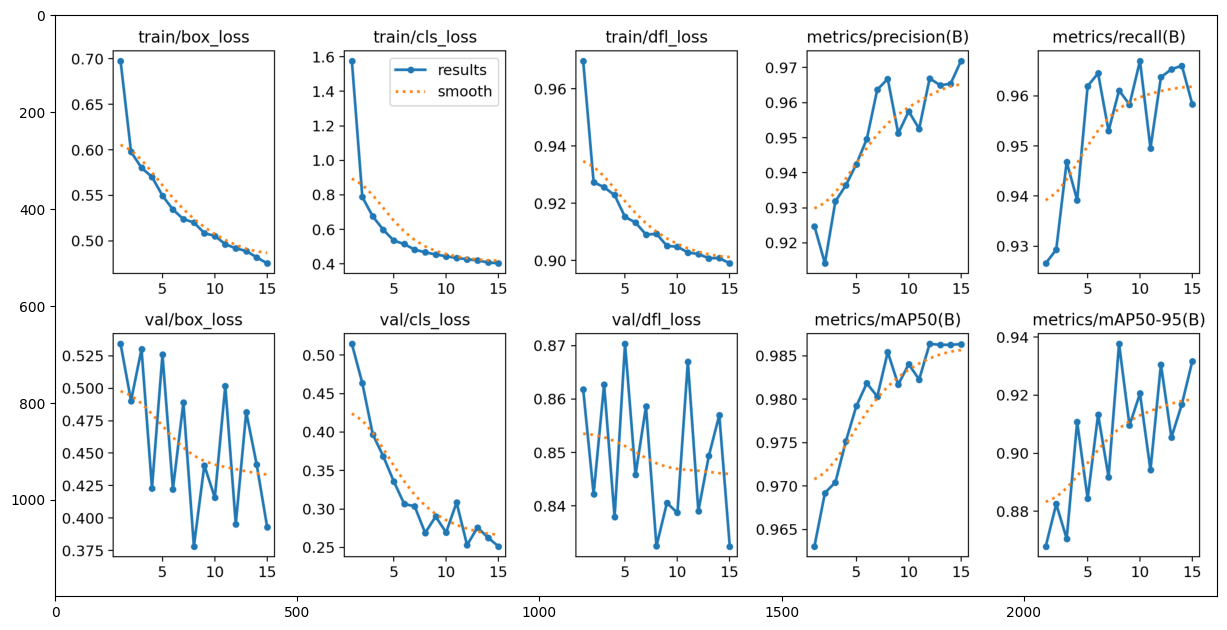

In [11]:
import matplotlib.pyplot as plt

results_img_path = '/content/runs/detect/train2/results.png'

# Load the image using imread
img = plt.imread(results_img_path)
# set image size
plt.figure(figsize=(15, 15))
# Display the image using imshow
plt.imshow(img)
plt.show()

In [12]:
model = YOLO('/content/runs/detect/train2/weights/best.pt')

In [13]:
results = model.val()

# You can print the whole thing
print(results)



Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,008,183 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/Capstone/yolo_dataset/labels/validation.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


                   all       1000       4323      0.966      0.961      0.985      0.937
            helicopter       1000       1000      0.991      0.998      0.994      0.947
              hospital        841        841      0.992      0.987      0.994      0.953
              mountain        248        281      0.969      0.996      0.988      0.932
                 skull        243        272      0.991          1      0.995      0.954
            skyscraper        258        284      0.964      0.955      0.987      0.945
               tractor        242        280      0.955      0.913      0.982      0.941
        traffic_lights        256        282      0.978      0.965      0.993      0.948
                  vans        234        263      0.875      0.943      0.954      0.909
                 trees        236        263          1       0.99      0.995      0.944
                 cloud        251        285      0.989      0.982      0.995      0.928
            fire_truc

In [14]:
# These are common keys; exact content can vary by task (detect/segment/etc)
print(f"mAP50-95: {results.box.map:.4f}")
print(f"mAP50: {results.box.map50:.4f}")
print(f"Number of classes: {results.box.nc}")
print(f"Per-class mAP: {results.box.maps}")  # List of mAP50-95 for each class


mAP50-95: 0.9373
mAP50: 0.9854
Number of classes: 13
Per-class mAP: [    0.93725      0.9468     0.95342     0.93191     0.95393      0.9446     0.94142     0.94781     0.90934     0.94416     0.92761      0.9088     0.93725]


In [15]:
print(f"Recall: {results.box.mr:.4f}")
print(f"Precision: {results.box.mp:.4f}")
print(f"mAP50-95: {results.box.map:.4f}")
print(f"mAP50: {results.box.map50:.4f}")

Recall: 0.9610
Precision: 0.9664
mAP50-95: 0.9373
mAP50: 0.9854


In [5]:
model = YOLO('/content/drive/MyDrive/Capstone/runs_tuned/detect/train/weights/best.pt')

In [ ]:
oldModel = YOLO('yolov8n.pt')
oldModel.load('/content/drive/MyDrive/Capstone/yolov8_model')

Transferred 58/355 items from pretrained weights


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
results = oldModel.val(data="/content/drive/MyDrive/Capstone/yolo_dataset/data.yaml")
print(f"Recall: {results.box.mr:.4f}")
print(f"Precision: {results.box.mp:.4f}")
print(f"mAP50-95: {results.box.map:.4f}")
print(f"mAP50: {results.box.map50:.4f}")
print(f"Number of classes: {results.box.nc}")

Ultralytics 8.3.105 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/drive/MyDrive/Capstone/yolo_dataset/labels/validation.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:35<00:00,  1.80it/s]


                   all       1000       4323   1.11e-05   0.000319   5.57e-06   5.57e-07
                person       1000       1000          0          0          0          0
               bicycle        841        841          0          0          0          0
                   car        248        281          0          0          0          0
            motorcycle        243        272          0          0          0          0
              airplane        258        284          0          0          0          0
                   bus        242        280          0          0          0          0
                 train        256        282          0          0          0          0
                 truck        234        263          0          0          0          0
                  boat        236        263          0          0          0          0
         traffic light        251        285   0.000122    0.00351   6.13e-05   6.13e-06
          fire hydran

In [ ]:
results = model.val(data='/content/drive/MyDrive/Capstone/yolo_dataset/data.yaml')
print(f"Recall: {results.box.mr:.4f}")
print(f"Precision: {results.box.mp:.4f}")
print(f"mAP50-95: {results.box.map:.4f}")
print(f"mAP50: {results.box.map50:.4f}")
print(f"Number of classes: {results.box.nc}")

Ultralytics 8.3.105 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/drive/MyDrive/Capstone/yolo_dataset/labels/validation... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:06<00:00, 164.58it/s]


val: New cache created: /content/drive/MyDrive/Capstone/yolo_dataset/labels/validation.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:07<00:00,  8.73it/s]


                   all       1000       4323     0.0502       0.56     0.0471     0.0421
               nothing       1000       1000     0.0833      0.008     0.0421     0.0221
            helicopter        841        841      0.123      0.831      0.137      0.125
              hospital        248        281     0.0403      0.587     0.0323     0.0301
              mountain        243        272    0.00627     0.0772    0.00338    0.00318
                 skull        258        284     0.0132      0.173    0.00779    0.00692
            skyscraper        242        280     0.0514      0.964     0.0552      0.052
               tractor        256        282     0.0394      0.564     0.0309      0.028
        traffic_lights        234        263     0.0409       0.76     0.0368     0.0341
                  vans        236        263     0.0538      0.802     0.0579     0.0537
                 trees        251        285      0.058      0.954     0.0845     0.0786
                 clou


image 1/1 /content/drive/MyDrive/Capstone/pen_test.png: 640x640 2 helicopters, 1 hospital, 3 mountains, 1 skull, 1 fire_truck, 11.0ms
Speed: 2.9ms preprocess, 11.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)
Bounding Box: tensor([285.8315, 264.2971, 378.5912, 353.5399], device='cuda:0') Confidence: tensor([0.9661], device='cuda:0')
Bounding Box: tensor([414.8285,  93.2181, 639.6420, 236.8778], device='cuda:0') Confidence: tensor([0.9560], device='cuda:0')
Bounding Box: tensor([308.3801, 380.4312, 382.1774, 465.6902], device='cuda:0') Confidence: tensor([0.9492], device='cuda:0')
Bounding Box: tensor([295.0416, 191.5587, 383.3970, 255.2528], device='cuda:0') Confidence: tensor([0.9425], device='cuda:0')
Bounding Box: tensor([156.3053, 270.9538, 255.2254, 355.7418], device='cuda:0') Confidence: tensor([0.9411], device='cuda:0')
Bounding Box: tensor([438.9529, 362.8804, 571.3335, 482.6048], device='cuda:0') Confidence: tensor([0.9256], device='cuda:0')
Bounding Box

array([[[246, 242, 245],
        [249, 245, 248],
        [247, 242, 245],
        ...,
        [247, 240, 245],
        [250, 246, 249],
        [245, 238, 243]],

       [[242, 238, 241],
        [248, 244, 246],
        [244, 240, 242],
        ...,
        [247, 240, 245],
        [242, 235, 240],
        [244, 238, 242]],

       [[245, 241, 243],
        [241, 236, 239],
        [248, 244, 247],
        ...,
        [244, 236, 241],
        [247, 240, 245],
        [244, 236, 241]],

       ...,

       [[231, 217, 218],
        [234, 220, 221],
        [233, 219, 220],
        ...,
        [241, 233, 238],
        [241, 232, 237],
        [238, 230, 235]],

       [[229, 215, 216],
        [225, 211, 212],
        [234, 220, 222],
        ...,
        [241, 232, 237],
        [239, 230, 236],
        [242, 234, 239]],

       [[231, 217, 218],
        [228, 214, 215],
        [233, 215, 217],
        ...,
        [240, 231, 236],
        [241, 232, 237],
        [241, 233, 238]]], dtype=uint8)
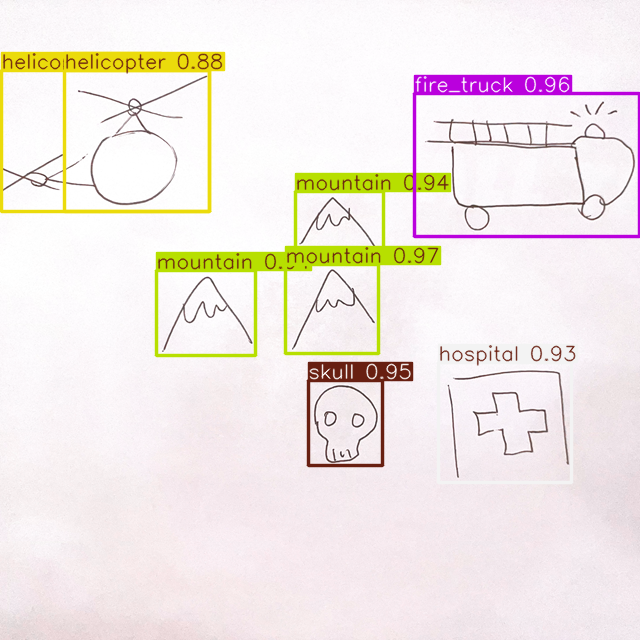

In [ ]:
img_path = '/content/drive/MyDrive/Capstone/pen_test.png'
results = model(img_path)

# Process results
for r in results:
    boxes = r.boxes
    for box in boxes:
      print(f"Bounding Box: {box.xyxy[0]} Confidence: {box.conf}")

results[0].plot()


In [16]:
# Define source and destination paths
source_path = '/content/runs'
destination_path = '/content/drive/MyDrive/Capstone'

# Create the destination directory if it doesn't exist
os.makedirs(destination_path, exist_ok=True)


# Use shutil.copytree to copy the directory and its contents recursively
try:
    shutil.copytree(source_path, os.path.join(destination_path, 'runs_best'), dirs_exist_ok=True)
    print(f"Successfully copied '{source_path}' to '{destination_path}'")
except FileExistsError:
    print(f"Directory '{os.path.join(destination_path, 'runs')}' already exists.")
except Exception as e:
    print(f"An error occurred: {e}")


Successfully copied '/content/runs' to '/content/drive/MyDrive/Capstone'


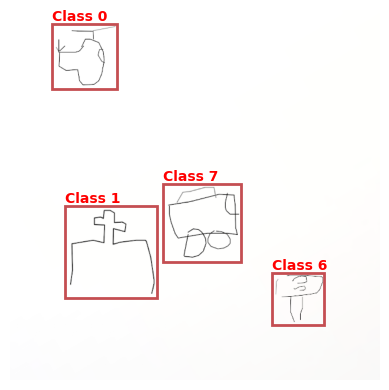

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

# Paths
validation_test_path = '/content/drive/MyDrive/Capstone/yolo_dataset/images/validation/image_1000.png'
validation_testlabel_path = '/content/drive/MyDrive/Capstone/yolo_dataset/labels/validation/image_1000.txt'

# Load image
image = plt.imread(validation_test_path)
h, w = image.shape[:2]

# Create plot
fig, ax = plt.subplots(1)
ax.imshow(image)

# Read label file and draw boxes
with open(validation_testlabel_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        parts = line.strip().split()
        cls_id = int(parts[0])
        xc = float(parts[1])
        yc = float(parts[2])
        bw = float(parts[3])
        bh = float(parts[4])

        # Convert normalized coords to pixel coords
        x = (xc - bw / 2) * w
        y = (yc - bh / 2) * h
        box_w = bw * w
        box_h = bh * h

        # Draw rectangle
        rect = patches.Rectangle((x, y), box_w, box_h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Optionally label with class ID
        ax.text(x, y - 5, f"Class {cls_id}", color='red', fontsize=10, weight='bold')

plt.axis('off')
plt.show()




In [ ]:
base_dir = '/content/drive/MyDrive/Capstone/yolo_dataset'
valid_labels_dir = os.path.join(base_dir, 'labels', 'validation')

for filename in os.listdir(valid_labels_dir):
    if filename.endswith(".txt"):
        filepath = os.path.join(valid_labels_dir, filename)
        with open(filepath, 'r') as f:
            lines = f.readlines()
        with open(filepath, 'w') as f:
            for line in lines:
                parts = line.strip().split()
                if parts:
                    cls_id = int(parts[0])
                    xc = float(parts[1])
                    yc = 1 - float(parts[2])  # Subtract y-center from 1
                    bw = float(parts[3])
                    bh = float(parts[4])
                    f.write(f"{cls_id} {xc} {yc} {bw} {bh}\n")


## Save Model

In [ ]:
model.save('/content/drive/MyDrive/Capstone/yolov8_model')

## Load Saved Model

In [ ]:
model.load('/content/drive/MyDrive/Capstone/yolov8_model')

## Export Model

In [ ]:
model.export(format='onnx')

Ultralytics 8.3.105 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'runs/detect/train5/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 17, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 193.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 292.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 168.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 220.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 287.8 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 13.1s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: s

'runs/detect/train5/weights/best.onnx'

## Hyperparameter Tuning

In [ ]:
import pandas as pd

# Path to the CSV from your training run
csv_path = "/content/runs/detect/train5/results.csv"

# Load and clean the data
df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip()  # Remove weird whitespace

# Find the epoch with the best mAP50 (or mAP50-95 if you prefer)
best_epoch = df['map50'].idxmax()
best_map = df['map50'].max()

print(f"Best mAP50 of {best_map:.4f} occurred at epoch {best_epoch}")


KeyError: 'map50'

In [ ]:
search_space = {
    "lr0": (1e-5, 1e-1),
    "degrees": (0.0, 45.0),
    "lrf": (1e-6, 1e-2),
    "momentum": (0.5, 0.95),
    "weight_decay": (1e-5, 1e-1),
    "warmup_epochs": (0, 3),
    "warmup_momentum": (0.5, 0.95),
    "warmup_bias_lr": (1e-6, 1e-2),
    "cls": (0.2, 2.0)
}

# Tune hyperparameters on COCO8 for 30 epochs
model.tune(
    data="/content/drive/MyDrive/Capstone/yolo_dataset/data.yaml",
    epochs=15,
    batch= 64,
    iterations=250,
    optimizer="AdamW",
    space=search_space,
    plots=False,
    save=False,
    val=False,
)

Tuner: Initialized Tuner instance with 'tune_dir=runs/detect/tune2'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/250 with hyperparameters: {'lr0': 0.01, 'degrees': 0.0, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'warmup_bias_lr': 0.01, 'cls': 0.5}
Saved runs/detect/tune2/tune_scatter_plots.png
Saved runs/detect/tune2/tune_fitness.png

Tuner: 1/250 iterations complete ✅ (1961.16s)
Tuner: Results saved to runs/detect/tune2
Tuner: Best fitness=0.00601 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.01192, 'metrics/recall(B)': 0.02641, 'metrics/mAP50(B)': 0.00634, 'metrics/mAP50-95(B)': 0.00598, 'val/box_loss': 0.44128, 'val/cls_loss': 11.78183, 'val/dfl_loss': 0.87165, 'fitness': 0.00601}
Tuner: Best fitness model is runs/detect/train2
Tuner: Best fitness hyperparameters are printed below.

Printing 'runs/detect/tune2/best_hy

In [ ]:
# train model using learning rate of 0.01028
model.train(data='/content/drive/MyDrive/Capstone/yolo_dataset/data.yaml',
            epochs=50,
            imgsz=640,
            lr0=0.01028,
            momentum = 0.90332,
            weight_decay = 0.0005,
            warmup_epochs = 3.0,
            warmup_momentum = 0.79954,
            warmup_bias_lr = 0.01
            )

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/Capstone/yolo_dataset/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True,

100%|██████████| 755k/755k [00:00<00:00, 157MB/s]


Overriding model.yaml nc=80 with nc=13

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 343MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/Capstone/yolo_dataset/labels/train.cache... 10000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Capstone/yolo_dataset/labels/validation.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01028' and 'momentum=0.90332' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000588, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       2.1G     0.6977      1.577     0.9698         90        640: 100%|██████████| 625/625 [18:07<00:00,  1.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  5.17it/s]


                   all       1000       4323     0.0265      0.918     0.0762     0.0589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.33G     0.5977     0.7879     0.9274        108        640: 100%|██████████| 625/625 [01:07<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  6.39it/s]

                   all       1000       4323     0.0649      0.552     0.0537     0.0446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.34G     0.5802     0.6749     0.9256         86        640: 100%|██████████| 625/625 [01:05<00:00,  9.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:05<00:00,  6.30it/s]

                   all       1000       4323     0.0513      0.537     0.0697     0.0623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.34G     0.5702     0.5981     0.9229         98        640: 100%|██████████| 625/625 [01:05<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.52it/s]

                   all       1000       4323     0.0453      0.375     0.0381     0.0359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.34G     0.5496     0.5354     0.9152        117        640: 100%|██████████| 625/625 [01:05<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.46it/s]

                   all       1000       4323      0.044      0.272     0.0318     0.0291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.35G     0.5344     0.5151     0.9133        130        640: 100%|██████████| 625/625 [01:05<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.83it/s]

                   all       1000       4323     0.0297      0.157     0.0195     0.0182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.37G     0.5239     0.4826     0.9091        135        640: 100%|██████████| 625/625 [01:05<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.49it/s]

                   all       1000       4323     0.0404      0.193     0.0323     0.0296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.37G     0.5202     0.4676     0.9093        114        640: 100%|██████████| 625/625 [01:05<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.72it/s]

                   all       1000       4323     0.0445      0.168     0.0351     0.0332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.37G     0.5085     0.4551     0.9051         82        640: 100%|██████████| 625/625 [01:05<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.55it/s]

                   all       1000       4323     0.0407      0.203     0.0445     0.0411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.37G     0.5054     0.4443     0.9048        102        640: 100%|██████████| 625/625 [01:05<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.95it/s]

                   all       1000       4323     0.0167      0.077    0.00992    0.00921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.37G     0.4963     0.4349     0.9028        102        640: 100%|██████████| 625/625 [01:05<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.64it/s]


                   all       1000       4323     0.0271      0.141     0.0187     0.0171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.37G     0.4918     0.4272     0.9022        118        640: 100%|██████████| 625/625 [01:05<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.82it/s]

                   all       1000       4323     0.0129     0.0464    0.00693    0.00651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.37G     0.4889     0.4205     0.9008        101        640: 100%|██████████| 625/625 [01:05<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.54it/s]

                   all       1000       4323     0.0305      0.132     0.0209     0.0192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.37G     0.4818     0.4086     0.9008        125        640: 100%|██████████| 625/625 [01:05<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.76it/s]

                   all       1000       4323     0.0196      0.104     0.0141     0.0131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.37G     0.4753     0.4033      0.899         97        640: 100%|██████████| 625/625 [01:05<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.58it/s]

                   all       1000       4323      0.022     0.0989     0.0145     0.0136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.37G     0.4602     0.3917     0.8956        110        640: 100%|██████████| 625/625 [01:05<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.76it/s]


                   all       1000       4323     0.0171     0.0594    0.00974    0.00926

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.37G     0.4434     0.3938     0.8934        117        640: 100%|██████████| 625/625 [01:05<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.52it/s]

                   all       1000       4323     0.0221     0.0658     0.0125     0.0116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.37G     0.4165     0.3816     0.8871         93        640: 100%|██████████| 625/625 [01:05<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.89it/s]

                   all       1000       4323     0.0196     0.0665     0.0111     0.0105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.37G     0.4098     0.3742     0.8851        102        640: 100%|██████████| 625/625 [01:05<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.51it/s]

                   all       1000       4323     0.0253       0.08     0.0148     0.0138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.37G     0.3995     0.3659     0.8833        103        640: 100%|██████████| 625/625 [01:05<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.77it/s]

                   all       1000       4323     0.0176     0.0498     0.0101    0.00974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.37G     0.3899     0.3576     0.8801         84        640: 100%|██████████| 625/625 [01:05<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.61it/s]

                   all       1000       4323      0.013     0.0428    0.00726    0.00686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.37G     0.3798     0.3505      0.878        126        640: 100%|██████████| 625/625 [01:06<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.74it/s]

                   all       1000       4323      0.015     0.0359      0.008    0.00754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.37G      0.381     0.3518     0.8789         78        640: 100%|██████████| 625/625 [01:05<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.60it/s]

                   all       1000       4323     0.0146     0.0462     0.0081    0.00773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.37G     0.3709     0.3493     0.8781        134        640: 100%|██████████| 625/625 [01:05<00:00,  9.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.82it/s]

                   all       1000       4323     0.0189     0.0565     0.0104     0.0099



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.37G     0.3658     0.3451     0.8771        133        640: 100%|██████████| 625/625 [01:05<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.59it/s]

                   all       1000       4323     0.0165     0.0536    0.00929    0.00902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.37G     0.3614     0.3385     0.8757        112        640: 100%|██████████| 625/625 [01:05<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.88it/s]

                   all       1000       4323    0.00721     0.0298    0.00384    0.00372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.37G     0.3585     0.3372     0.8757        119        640: 100%|██████████| 625/625 [01:05<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.71it/s]

                   all       1000       4323     0.0108     0.0276    0.00566    0.00551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.37G     0.3594     0.3333     0.8742        112        640: 100%|██████████| 625/625 [01:05<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.80it/s]

                   all       1000       4323     0.0104     0.0288    0.00554     0.0053



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.37G     0.3449      0.327     0.8695         85        640: 100%|██████████| 625/625 [01:06<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.73it/s]


                   all       1000       4323     0.0086     0.0247    0.00448    0.00435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.37G     0.3442     0.3283     0.8697        120        640: 100%|██████████| 625/625 [01:05<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.81it/s]

                   all       1000       4323     0.0141      0.035    0.00768    0.00736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.37G     0.3436     0.3258     0.8696        102        640: 100%|██████████| 625/625 [01:05<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.74it/s]

                   all       1000       4323    0.00746     0.0208    0.00388     0.0037



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.37G     0.3324      0.315     0.8661        104        640: 100%|██████████| 625/625 [01:05<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.83it/s]

                   all       1000       4323    0.00832     0.0204    0.00434    0.00417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.37G     0.3333     0.3124     0.8661        122        640: 100%|██████████| 625/625 [01:05<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.57it/s]

                   all       1000       4323    0.00792     0.0181    0.00415    0.00394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.37G     0.3249     0.3081     0.8654        121        640: 100%|██████████| 625/625 [01:05<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.84it/s]


                   all       1000       4323     0.0105     0.0247    0.00559    0.00527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.37G     0.3255     0.3075     0.8663         86        640: 100%|██████████| 625/625 [01:06<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.79it/s]


                   all       1000       4323    0.00774     0.0194    0.00404    0.00387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.37G     0.3255     0.3086     0.8677        133        640: 100%|██████████| 625/625 [01:06<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.92it/s]

                   all       1000       4323    0.00836     0.0186    0.00433    0.00412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.37G     0.3133     0.2973     0.8633        106        640: 100%|██████████| 625/625 [01:05<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.64it/s]

                   all       1000       4323       0.01      0.023    0.00524    0.00509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.37G     0.3131     0.2994     0.8634         75        640: 100%|██████████| 625/625 [01:05<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.78it/s]

                   all       1000       4323    0.00887     0.0198    0.00458    0.00435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.37G     0.3116     0.2939     0.8633        115        640: 100%|██████████| 625/625 [01:05<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.64it/s]

                   all       1000       4323    0.00787     0.0167    0.00408     0.0039



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.37G     0.3083     0.2938      0.862        120        640: 100%|██████████| 625/625 [01:05<00:00,  9.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.01it/s]


                   all       1000       4323    0.00928     0.0223    0.00488    0.00464
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.37G     0.2327     0.2076     0.8248         66        640: 100%|██████████| 625/625 [01:05<00:00,  9.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.65it/s]

                   all       1000       4323    0.00983     0.0213    0.00513    0.00491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.37G     0.2248      0.202     0.8213         62        640: 100%|██████████| 625/625 [01:05<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.74it/s]

                   all       1000       4323    0.00813      0.018     0.0042    0.00404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.37G     0.2233     0.1954     0.8215         73        640: 100%|██████████| 625/625 [01:04<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.75it/s]

                   all       1000       4323    0.00707     0.0147    0.00362    0.00347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.37G     0.2167      0.193     0.8198         64        640: 100%|██████████| 625/625 [01:04<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.90it/s]


                   all       1000       4323    0.00556     0.0123    0.00285    0.00271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.37G     0.2145     0.1893     0.8187         63        640: 100%|██████████| 625/625 [01:04<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.69it/s]

                   all       1000       4323    0.00514    0.00995    0.00261    0.00254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.37G     0.2119     0.1879     0.8175         69        640: 100%|██████████| 625/625 [01:04<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.75it/s]

                   all       1000       4323    0.00619     0.0128    0.00318    0.00301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.37G     0.2089     0.1861     0.8178         72        640: 100%|██████████| 625/625 [01:04<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.92it/s]


                   all       1000       4323    0.00554     0.0117    0.00283    0.00279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.37G      0.205     0.1797     0.8146         69        640: 100%|██████████| 625/625 [01:05<00:00,  9.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.60it/s]


                   all       1000       4323    0.00451    0.00965     0.0023    0.00226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.37G     0.2033      0.178     0.8172         67        640: 100%|██████████| 625/625 [01:04<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.01it/s]

                   all       1000       4323    0.00501    0.00944    0.00255    0.00248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.37G     0.2034     0.1775     0.8166         68        640: 100%|██████████| 625/625 [01:04<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.57it/s]


                   all       1000       4323    0.00572     0.0116    0.00293    0.00286

50 epochs completed in 1.265 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,008,183 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:06<00:00,  5.01it/s]


                   all       1000       4323     0.0513      0.537     0.0697     0.0623
               nothing       1000       1000          0          0          0          0
            helicopter        841        841      0.128      0.857      0.145      0.125
              hospital        248        281     0.0424      0.605     0.0345     0.0306
              mountain        243        272    0.00344     0.0257    0.00177    0.00159
                 skull        258        284     0.0132     0.0915    0.00719    0.00651
            skyscraper        242        280     0.0714      0.957     0.0772     0.0705
               tractor        256        282     0.0575      0.716     0.0509     0.0447
        traffic_lights        234        263     0.0683      0.817     0.0722     0.0664
                  vans        236        263     0.0748      0.776     0.0666     0.0607
                 trees        251        285     0.0874      0.986      0.301       0.27
                 clou

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ebffe729290>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.

In [ ]:
results = model.val()


Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)


val: Scanning /content/drive/MyDrive/Capstone/yolo_dataset/labels/validation.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:08<00:00,  7.83it/s]


                   all       1000       4323     0.0512      0.538     0.0697     0.0624
               nothing       1000       1000          0          0          0          0
            helicopter        841        841      0.128      0.859      0.146      0.125
              hospital        248        281     0.0425      0.609     0.0346     0.0307
              mountain        243        272    0.00391     0.0294    0.00201    0.00181
                 skull        258        284     0.0131     0.0915    0.00717    0.00647
            skyscraper        242        280     0.0713      0.957     0.0773     0.0706
               tractor        256        282     0.0572      0.716     0.0508     0.0448
        traffic_lights        234        263     0.0684      0.821     0.0723     0.0666
                  vans        236        263     0.0743      0.772     0.0663     0.0605
                 trees        251        285     0.0873      0.986      0.302      0.271
                 clou

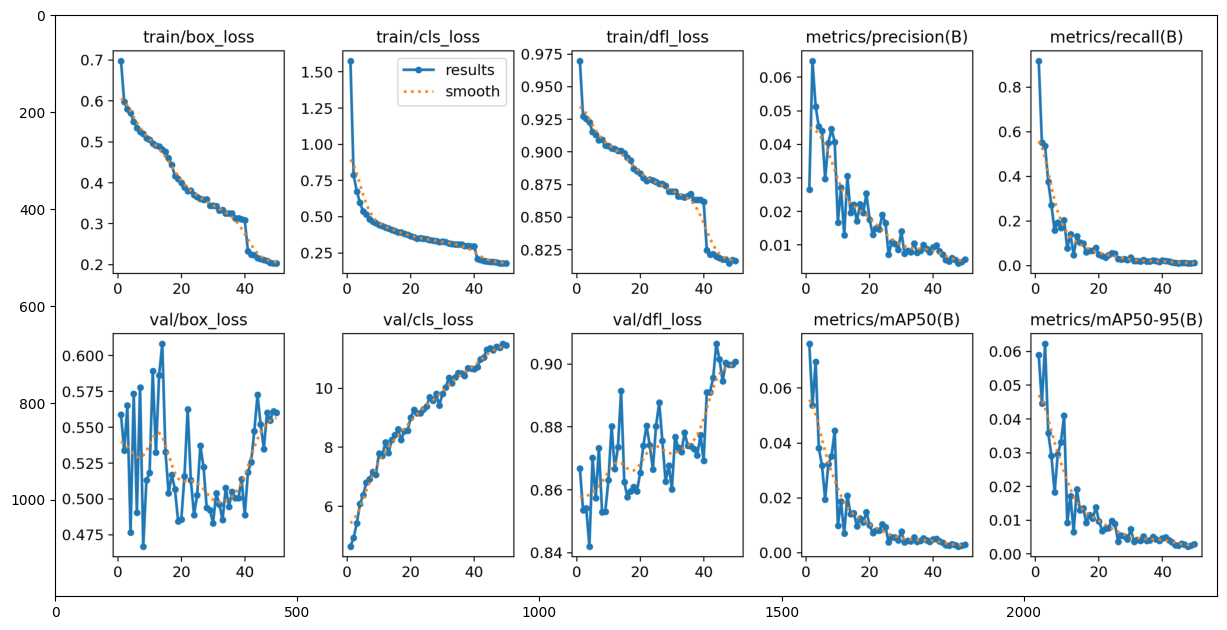

In [ ]:
import matplotlib.pyplot as plt

results_img_path = '/content/runs/detect/train/results.png'

# Load the image using imread
img = plt.imread(results_img_path)
# set image size
plt.figure(figsize=(15, 15))
# Display the image using imshow
plt.imshow(img)
plt.show()

In [ ]:
results = model.val(data="/content/drive/MyDrive/Capstone/yolo_dataset/data.yaml")
print(f"Recall: {results.box.mr:.4f}")
print(f"Precision: {results.box.mp:.4f}")
print(f"mAP50-95: {results.box.map:.4f}")
print(f"mAP50: {results.box.map50:.4f}")
print(f"Number of classes: {results.box.nc}")

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)


val: Scanning /content/drive/MyDrive/Capstone/yolo_dataset/labels/validation.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:10<00:00,  5.73it/s]


                   all       1000       4323     0.0512      0.538     0.0697     0.0624
               nothing       1000       1000          0          0          0          0
            helicopter        841        841      0.128      0.859      0.146      0.125
              hospital        248        281     0.0425      0.609     0.0346     0.0307
              mountain        243        272    0.00391     0.0294    0.00201    0.00181
                 skull        258        284     0.0131     0.0915    0.00717    0.00647
            skyscraper        242        280     0.0713      0.957     0.0773     0.0706
               tractor        256        282     0.0572      0.716     0.0508     0.0448
        traffic_lights        234        263     0.0684      0.821     0.0723     0.0666
                  vans        236        263     0.0743      0.772     0.0663     0.0605
                 trees        251        285     0.0873      0.986      0.302      0.271
                 clou

In [ ]:
print(f"Recall: {results.box.mr:.4f}")
print(f"Precision: {results.box.mp:.4f}")
print(f"mAP50-95: {results.box.map:.4f}")
print(f"mAP50: {results.box.map50:.4f}")

Recall: 0.5376
Precision: 0.0512
mAP50-95: 0.0624
mAP50: 0.0697


In [ ]:
model = YOLO('/content/runs/detect/train/weights/best.pt')


In [ ]:
results = model.val()
print(f"Recall: {results.box.mr:.4f}")
print(f"Precision: {results.box.mp:.4f}")
print(f"mAP50-95: {results.box.map:.4f}")
print(f"mAP50: {results.box.map50:.4f}")

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,008,183 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/Capstone/yolo_dataset/labels/validation.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


                   all       1000       4323     0.0512      0.538     0.0697     0.0624
               nothing       1000       1000          0          0          0          0
            helicopter        841        841      0.128      0.859      0.146      0.125
              hospital        248        281     0.0425      0.609     0.0346     0.0307
              mountain        243        272    0.00391     0.0294    0.00201    0.00181
                 skull        258        284     0.0131     0.0915    0.00717    0.00647
            skyscraper        242        280     0.0713      0.957     0.0773     0.0706
               tractor        256        282     0.0572      0.716     0.0508     0.0448
        traffic_lights        234        263     0.0684      0.821     0.0723     0.0666
                  vans        236        263     0.0743      0.772     0.0663     0.0605
                 trees        251        285     0.0873      0.986      0.302      0.271
                 clou

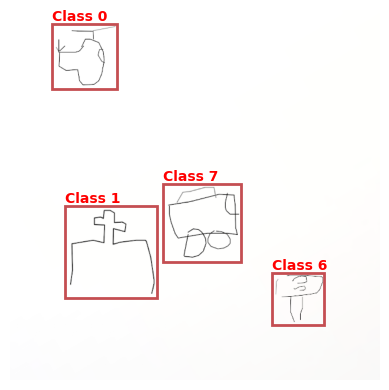

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

validation_test_path = '/content/drive/MyDrive/Capstone/yolo_dataset/images/validation/image_1000.png'
validation_testlabel_path = '/content/drive/MyDrive/Capstone/yolo_dataset/labels/validation/image_1000.txt'

# Load image
image = plt.imread(validation_test_path)
h, w = image.shape[:2]

# Create plot
fig, ax = plt.subplots(1)
ax.imshow(image)

# Read label file and draw boxes
with open(validation_testlabel_path, 'r') as f:
    lines = f.readlines()
    for line in lines:
        parts = line.strip().split()
        cls_id = int(parts[0])
        xc = float(parts[1])
        yc = float(parts[2])
        bw = float(parts[3])
        bh = float(parts[4])

        # Convert normalized coords to pixel coords
        x = (xc - bw / 2) * w
        y = (yc - bh / 2) * h
        box_w = bw * w
        box_h = bh * h

        # Draw rectangle
        rect = patches.Rectangle((x, y), box_w, box_h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Optionally label with class ID
        ax.text(x, y - 5, f"Class {cls_id}", color='red', fontsize=10, weight='bold')

plt.axis('off')
plt.show()


In [ ]:
results = model.val(data="/content/drive/MyDrive/Capstone/test/test/test_data.yaml")
print(f"Recall: {results.box.mr:.4f}")
print(f"Precision: {results.box.mp:.4f}")
print(f"mAP50-95: {results.box.map:.4f}")
print(f"mAP50: {results.box.map50:.4f}")
print(f"Number of classes: {results.box.nc}")

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,008,183 parameters, 0 gradients, 8.1 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 19.6MB/s]
val: Scanning /content/drive/MyDrive/Capstone/test/test/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:01<00:00,  6.99it/s]

val: New cache created: /content/drive/MyDrive/Capstone/test/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


                   all         10         39     0.0636      0.642      0.112     0.0826
               nothing          1          1          0          0          0          0
            helicopter          3          3     0.0377      0.667     0.0452     0.0346
              hospital          3          3     0.0606      0.667     0.0735     0.0541
              mountain         10         10          0          0          0          0
                 skull          5          5     0.0714        0.2     0.0439     0.0351
            skyscraper          3          3     0.0938          1      0.373      0.299
               tractor          1          1     0.0455          1     0.0829      0.058
        traffic_lights          2          3      0.087      0.667      0.142     0.0864
                  vans          2          2       0.08          1      0.112     0.0815
                 trees          1          1     0.0312          1     0.0829      0.058
                 clou

In [8]:
model = YOLO('/content/drive/MyDrive/Capstone/runs/detect/train/weights/best.pt')

In [18]:
search_space = {
    "lr0": (0.001, 0.1), # default lr 0.01
    "weight_decay": (0.00005, 0.005), # default is 0.0005
    "warmup_epochs": (0, 6), # default is 3
    "warmup_bias_lr": (0.001, 0.5), # default is 0.1
    "cls": (0.2, 1.0), # default is 0.5

}


model.tune(
    data="/content/drive/MyDrive/Capstone/yolo_dataset/data.yaml",
    epochs=50,
    iterations=100,
    optimizer="AdamW",
    space=search_space,
    plots=False,
    save=False,
    val=True,
    patience=5,
    batch=32,
    imgsz=640
)


Tuner: Initialized Tuner instance with 'tune_dir=runs/detect/tune2'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/100 with hyperparameters: {'lr0': 0.01, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_bias_lr': 0.1, 'cls': 0.5}
WARNING ❌️ training failure for hyperparameter tuning iteration 1
Command '['/usr/bin/python3', '-m', 'ultralytics.cfg.__init__', 'train', 'task=detect', 'mode=train', 'model=/content/runs/detect/train2/weights/best.pt', 'data=/content/drive/MyDrive/Capstone/yolo_dataset/data.yaml', 'epochs=50', 'time=None', 'patience=5', 'batch=32', 'imgsz=640', 'save=False', 'save_period=-1', 'cache=False', 'device=None', 'workers=8', 'project=None', 'name=None', 'exist_ok=False', 'pretrained=True', 'optimizer=AdamW', 'verbose=True', 'seed=0', 'deterministic=True', 'single_cls=False', 'rect=False', 'cos_lr=False', 'close_mosaic=10', 'resume=False', 'amp=True', 'fraction=1.0', 'profile=False', 'freeze

KeyboardInterrupt: 

In [19]:
model.train(
    data="/content/drive/MyDrive/Capstone/yolo_dataset/data.yaml",
    epochs=50,
    patience=7,
    batch=64,
    lr0=0.0759,
    weight_decay=0.0071,
    cls=0.8733
            )


Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/train2/weights/best.pt, data=/content/drive/MyDrive/Capstone/yolo_dataset/data.yaml, epochs=50, time=None, patience=7, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, s

train: Scanning /content/drive/MyDrive/Capstone/yolo_dataset/labels/train.cache... 10000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Capstone/yolo_dataset/labels/validation.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


Plotting labels to runs/detect/train9/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0759' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000588, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0071), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train9
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      7.97G     0.9203       1.74      1.109        120        640: 100%|██████████| 157/157 [02:02<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all       1000       4323      0.958      0.958      0.983      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      9.16G     0.5559     0.8915     0.9283        114        640: 100%|██████████| 157/157 [01:02<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.53it/s]

                   all       1000       4323      0.963      0.961      0.985      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      9.16G     0.5321     0.8254     0.9178        135        640: 100%|██████████| 157/157 [01:02<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.53it/s]

                   all       1000       4323      0.966       0.95      0.985      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      9.16G      0.521     0.7923     0.9113         99        640: 100%|██████████| 157/157 [01:02<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

                   all       1000       4323      0.953      0.966      0.984      0.925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      9.16G     0.5133     0.7605     0.9096         94        640: 100%|██████████| 157/157 [01:02<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]

                   all       1000       4323      0.962      0.962      0.985        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      9.16G     0.5075     0.7483     0.9079        128        640: 100%|██████████| 157/157 [01:02<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.48it/s]

                   all       1000       4323      0.962      0.971      0.987      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      9.16G     0.4987     0.7163     0.9032        122        640: 100%|██████████| 157/157 [01:02<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.49it/s]

                   all       1000       4323      0.958      0.954      0.985      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      9.16G     0.4955     0.7127     0.9023        113        640: 100%|██████████| 157/157 [01:02<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]

                   all       1000       4323       0.96       0.96      0.986      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      9.16G     0.4917     0.6994     0.9015        136        640: 100%|██████████| 157/157 [01:02<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

                   all       1000       4323      0.969      0.968      0.988      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      9.16G     0.4842      0.686     0.8984        103        640: 100%|██████████| 157/157 [01:02<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.50it/s]

                   all       1000       4323      0.967      0.964      0.987      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      9.16G     0.4814     0.6796     0.8973        105        640: 100%|██████████| 157/157 [01:02<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]

                   all       1000       4323       0.97      0.962      0.987      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      9.16G     0.4783     0.6712      0.898        119        640: 100%|██████████| 157/157 [01:02<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all       1000       4323      0.969      0.963      0.987      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      9.16G     0.4743     0.6605     0.8955         97        640: 100%|██████████| 157/157 [01:02<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]

                   all       1000       4323      0.965       0.97      0.988      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      9.16G     0.4755     0.6611     0.8972        119        640: 100%|██████████| 157/157 [01:02<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.48it/s]

                   all       1000       4323      0.971      0.965      0.988      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      9.16G     0.4681     0.6478     0.8941        104        640: 100%|██████████| 157/157 [01:02<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]

                   all       1000       4323      0.972      0.965      0.988      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      9.16G     0.4635     0.6332     0.8928        108        640: 100%|██████████| 157/157 [01:02<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.40it/s]

                   all       1000       4323      0.969      0.967      0.988      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      9.16G     0.4634     0.6383     0.8924         98        640: 100%|██████████| 157/157 [01:04<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.51it/s]

                   all       1000       4323      0.967      0.976      0.989      0.939
EarlyStopping: Training stopped early as no improvement observed in last 7 epochs. Best results observed at epoch 10, best model saved as best.pt.
To update EarlyStopping(patience=7) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



17 epochs completed in 0.341 hours.
Optimizer stripped from runs/detect/train9/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train9/weights/best.pt, 6.2MB

Validating runs/detect/train9/weights/best.pt...
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,008,183 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


                   all       1000       4323      0.968      0.961      0.987      0.946
            helicopter       1000       1000      0.997          1      0.995      0.944
              hospital        841        841      0.994      0.994      0.995      0.966
              mountain        248        281      0.954      0.996      0.983      0.936
                 skull        243        272      0.994          1      0.995      0.964
            skyscraper        258        284      0.991      0.944      0.991      0.951
               tractor        242        280      0.937      0.964      0.986       0.95
        traffic_lights        256        282      0.978      0.975      0.992      0.949
                  vans        234        263      0.935      0.826      0.965      0.935
                 trees        236        263          1      0.977      0.995      0.936
                 cloud        251        285      0.966      0.989      0.994      0.954
            fire_truc

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e30932abe90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.

In [21]:
model = YOLO('runs/detect/train9/weights/best.pt')

In [22]:
results = model.val(data="/content/drive/MyDrive/Capstone/yolo_dataset/data.yaml")
print(f"Recall: {results.box.mr:.4f}")
print(f"Precision: {results.box.mp:.4f}")
print(f"mAP50-95: {results.box.map:.4f}")
print(f"mAP50: {results.box.map50:.4f}")
print(f"Number of classes: {results.box.nc}")

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,008,183 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/Capstone/yolo_dataset/labels/validation.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:13<00:00,  4.50it/s]


                   all       1000       4323      0.967      0.964      0.987      0.947
            helicopter       1000       1000      0.996          1      0.995      0.945
              hospital        841        841      0.993      0.995      0.995      0.965
              mountain        248        281      0.954      0.996      0.983      0.937
                 skull        243        272      0.994          1      0.995      0.965
            skyscraper        258        284      0.989      0.948      0.991      0.952
               tractor        242        280      0.934      0.964      0.986      0.953
        traffic_lights        256        282      0.976      0.975      0.992       0.95
                  vans        234        263      0.936      0.839      0.965      0.935
                 trees        236        263          1      0.978      0.995      0.937
                 cloud        251        285      0.965      0.989      0.994      0.954
            fire_truc

In [23]:
model = YOLO('yolov8n.pt')
model.train(
    data="/content/drive/MyDrive/Capstone/yolo_dataset/data.yaml",
    epochs=50,
    patience=6,
    batch=32,
    lr0=0.0531,
    weight_decay=0.0071,
    cls=0.7386
            )

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/Capstone/yolo_dataset/data.yaml, epochs=50, time=None, patience=6, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True,

train: Scanning /content/drive/MyDrive/Capstone/yolo_dataset/labels/train.cache... 10000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Capstone/yolo_dataset/labels/validation.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


Plotting labels to runs/detect/train10/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0531' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000588, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0071), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train10
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.07G     0.7193      2.557     0.9791         86        640: 100%|██████████| 313/313 [02:41<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]

                   all       1000       4323      0.909      0.906      0.957      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.67G     0.5971      1.156     0.9278        102        640: 100%|██████████| 313/313 [01:02<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.75it/s]

                   all       1000       4323       0.95      0.935      0.974      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.67G     0.5743     0.9883     0.9197         96        640: 100%|██████████| 313/313 [01:01<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]

                   all       1000       4323      0.929      0.939      0.971      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.67G     0.5676     0.8806     0.9201         96        640: 100%|██████████| 313/313 [01:01<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]

                   all       1000       4323      0.932       0.95       0.98      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.67G     0.5552     0.7976     0.9181         99        640: 100%|██████████| 313/313 [01:01<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.60it/s]

                   all       1000       4323      0.951      0.953      0.981      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.68G     0.5427     0.7552     0.9162        148        640: 100%|██████████| 313/313 [01:01<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]

                   all       1000       4323      0.952      0.942      0.981      0.911



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.68G     0.5314     0.7119     0.9122        142        640: 100%|██████████| 313/313 [01:02<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.97it/s]

                   all       1000       4323      0.948      0.963      0.985      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.68G     0.5293      0.694     0.9118        107        640: 100%|██████████| 313/313 [01:01<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.97it/s]


                   all       1000       4323      0.957      0.953      0.983      0.907

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.68G     0.5196     0.6714     0.9102         78        640: 100%|██████████| 313/313 [01:01<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.63it/s]

                   all       1000       4323      0.938      0.966      0.982       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.68G     0.5161     0.6481     0.9104         90        640: 100%|██████████| 313/313 [01:01<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.73it/s]


                   all       1000       4323      0.963      0.959      0.984       0.89

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.68G     0.5117     0.6475     0.9091        106        640: 100%|██████████| 313/313 [01:01<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]

                   all       1000       4323      0.961      0.964      0.986      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.68G     0.5016     0.6268     0.9064        115        640: 100%|██████████| 313/313 [01:02<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]


                   all       1000       4323      0.953       0.97      0.986      0.926

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.68G     0.4962     0.6158     0.9052        115        640: 100%|██████████| 313/313 [01:01<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.64it/s]

                   all       1000       4323      0.964      0.966      0.988      0.902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.68G     0.4949     0.6145      0.906        116        640: 100%|██████████| 313/313 [01:02<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]

                   all       1000       4323      0.968      0.972      0.987      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.68G     0.4865     0.5966     0.9024        100        640: 100%|██████████| 313/313 [01:01<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.61it/s]


                   all       1000       4323      0.966      0.968      0.987      0.912

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.68G       0.48     0.5843     0.9006        110        640: 100%|██████████| 313/313 [01:01<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.67it/s]

                   all       1000       4323      0.967      0.967      0.986      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.68G     0.4779     0.5828     0.8996        129        640: 100%|██████████| 313/313 [01:01<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]


                   all       1000       4323      0.971      0.965      0.988      0.916

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.68G     0.4734     0.5777     0.8988         95        640: 100%|██████████| 313/313 [01:01<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.60it/s]

                   all       1000       4323      0.964      0.975      0.987      0.918
EarlyStopping: Training stopped early as no improvement observed in last 6 epochs. Best results observed at epoch 12, best model saved as best.pt.
To update EarlyStopping(patience=6) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



18 epochs completed in 0.371 hours.
Optimizer stripped from runs/detect/train10/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train10/weights/best.pt, 6.2MB

Validating runs/detect/train10/weights/best.pt...
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,008,183 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]


                   all       1000       4323      0.954       0.97      0.986      0.926
            helicopter       1000       1000      0.992          1      0.994      0.936
              hospital        841        841      0.959      0.998      0.993      0.941
              mountain        248        281      0.986      0.997      0.993       0.93
                 skull        243        272      0.995      0.996      0.995      0.921
            skyscraper        258        284      0.951      0.952      0.988      0.937
               tractor        242        280      0.931      0.961      0.987      0.936
        traffic_lights        256        282      0.973      0.982      0.994       0.94
                  vans        234        263      0.916      0.875      0.956      0.883
                 trees        236        263      0.989      0.992      0.995      0.948
                 cloud        251        285      0.983      0.988      0.994      0.921
            fire_truc

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e30ec1eb350>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.

In [24]:
results = model.val(data="/content/drive/MyDrive/Capstone/yolo_dataset/data.yaml")
model = YOLO('runs/detect/train10/weights/best.pt')
print(f"Recall: {results.box.mr:.4f}")
print(f"Precision: {results.box.mp:.4f}")
print(f"mAP50-95: {results.box.map:.4f}")
print(f"mAP50: {results.box.map50:.4f}")
print(f"Number of classes: {results.box.nc}")

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,008,183 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/Capstone/yolo_dataset/labels/validation.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:17<00:00,  1.81it/s]


                   all       1000       4323      0.954       0.97      0.986      0.927
            helicopter       1000       1000      0.991      0.999      0.994      0.936
              hospital        841        841      0.959      0.998      0.993      0.942
              mountain        248        281      0.986      0.997      0.993      0.931
                 skull        243        272      0.995      0.996      0.995      0.921
            skyscraper        258        284      0.951      0.952      0.988      0.939
               tractor        242        280      0.931      0.961      0.986      0.934
        traffic_lights        256        282      0.973      0.982      0.994      0.939
                  vans        234        263      0.912      0.875      0.956      0.884
                 trees        236        263      0.989      0.992      0.995      0.949
                 cloud        251        285      0.983      0.987      0.994      0.923
            fire_truc

In [ ]:
model.train(
    data="/content/drive/MyDrive/Capstone/yolo_dataset/data.yaml",
    epochs=50,
    patience=7,
    batch=64,
    lr0=0.98,
    weight_decay=0.001,
    cls=0.2428
            )

Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=detect, mode=train, model=runs/detect/train10/weights/best.pt, data=/content/drive/MyDrive/Capstone/yolo_dataset/data.yaml, epochs=50, time=None, patience=7, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train11, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_lab

train: Scanning /content/drive/MyDrive/Capstone/yolo_dataset/labels/train.cache... 10000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Capstone/yolo_dataset/labels/validation.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


Plotting labels to runs/detect/train11/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.98' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000588, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train11
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/157 [00:00<?, ?it/s]